In [1]:
import h5py
import torch
from torch.utils.data import Dataset
import numpy as np

class FGNetH5Dataset(Dataset):
    def __init__(self, h5_files, mask):
        """
        h5_files: list of paths
        mask: numpy array of shape (1,1,H,1)
        """
        self.h5_files = h5_files
        self.mask = torch.from_numpy(mask).float()  # (1,1,H,1)

        self.index_map = []
        for fidx, path in enumerate(h5_files):
            with h5py.File(path, "r") as f:
                num_slices = f["image_full"].shape[0]
                for s in range(num_slices):
                    self.index_map.append((fidx, s))

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        file_idx, slice_idx = self.index_map[idx]
        path = self.h5_files[file_idx]

        with h5py.File(path, "r") as f:
            img_us   = f["image_under"][slice_idx]        # (H,W,2)
            img_gt   = f["image_full"][slice_idx]         # (H,W,2)
            kspace   = f["kspace_full"][slice_idx]        # (H,W,2)
            img_unet = f["image_unet_pred"][slice_idx]    # (H,W,2)
            max_val  = float(f["max_val_full_image"][0])

        # to torch
        img_us   = torch.from_numpy(img_us).float()
        img_gt   = torch.from_numpy(img_gt).float()
        kspace   = torch.from_numpy(kspace).float()
        img_unet = torch.from_numpy(img_unet).float()
        max_val  = torch.tensor(max_val).float()

        return {
            "img_us": img_us,           # (H,W,2)
            "img_gt": img_gt,           # (H,W,2)
            "kspace": kspace,           # (H,W,2)
            "img_unet": img_unet,       # (H,W,2)
            "mask": self.mask.clone(),  # (1,1,H,1)
            "max_val": max_val
        }


In [2]:
import torch

def complex_abs(x):
    """
    x: (..., 2) where last dim is [real, imag]
    returns: magnitude
    """
    return torch.sqrt(x[..., 0]**2 + x[..., 1]**2 + 1e-8)


In [3]:
from pytorch_msssim import ssim

LAMBDA = 0.005   # λ in paper
GAMMA  = 0.01    # γ in paper

def compute_loss(out, out1, img_gt, img_unet):
    """
    out   : (B,H,W,2)    final DC output
    out1  : (B,1,H,W,2)  predicted residual
    """

    # -------------------------
    # Loss 1: main loss
    # -------------------------
    loss_l1 = F.l1_loss(out, img_gt)

    out_mag = complex_abs(out).unsqueeze(1)     # (B,1,H,W)
    gt_mag  = complex_abs(img_gt).unsqueeze(1)

    #loss_ssim = 1.0 - ssim(out_mag, gt_mag, data_range=1.0)
    #loss1 = loss_l1 + LAMBDA * loss_ssim
    loss1 = loss_l1 

    # -------------------------
    # Loss 2: auxiliary loss
    # -------------------------
    r_pred = out1.squeeze(1)            # (B,H,W,2)
    r_gt   = img_gt - img_unet          # GT–UNet residual

    loss_r_img = F.l1_loss(r_pred, r_gt)

    # r_pred_k = fft2c_new(r_pred)
    # r_gt_k   = fft2c_new(r_gt)

    # loss_r_k = F.l1_loss(r_pred_k, r_gt_k)

    #loss2 = loss_r_img + loss_r_k
    loss2 = loss_r_img 

    # -------------------------
    # Total loss
    # -------------------------
    return loss1 + GAMMA * loss2


In [4]:
%run HFGN_Model.ipynb

In [5]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm



# -------------------------
# Config
# -------------------------
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("DEVICE",DEVICE)
EPOCHS = 50
BATCH_SIZE = 8
LR = 1e-4

MASK_PATH = r"./mask_4x_320_random.npy"

train_folder = r"E:\DATA\fastmri_single_coil_FSSCAN_4x\train_norm"
val_folder = r"E:\DATA\fastmri_single_coil_FSSCAN_4x\val_norm"
import h5py
import numpy as np
import glob
import os
TRAIN_H5 = sorted(glob.glob(os.path.join(train_folder, "*.h5")))
VAL_H5 = sorted(glob.glob(os.path.join(val_folder, "*.h5")))

# half_train = 20
# half_val = 10
half_train = len(TRAIN_H5) 
half_val = len(VAL_H5) 
print("half_train",half_train)
print("half_val",half_val)
TRAIN_H5 = TRAIN_H5[:]
VAL_H5 = VAL_H5[:]


DEVICE cuda
half_train 973
half_val 199


In [6]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm

# -------------------------
# Load mask
# -------------------------
mask = np.load(MASK_PATH)   # (1,1,H,1)

# -------------------------
# Data
# -------------------------
train_ds = FGNetH5Dataset(TRAIN_H5, mask)
val_ds   = FGNetH5Dataset(VAL_H5, mask)

train_loader = DataLoader(
    train_ds, batch_size=20,
    shuffle=True)

val_loader = DataLoader(
    val_ds, batch_size=1,
    shuffle=False
)

# -------------------------
# Model
# -------------------------
model = FGNet().to(DEVICE)
optimizer = Adam(model.parameters(), lr=LR)

# -------------------------
# Tracking variables
# -------------------------
train_loss_curve = []
val_nmse_curve   = []
best_nmse = float("inf")

# -------------------------
# Training loop
# -------------------------
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for batch in pbar:
        img_us   = batch["img_us"].to(DEVICE)
        img_gt   = batch["img_gt"].to(DEVICE)
        kspace   = batch["kspace"].to(DEVICE)
        img_unet = batch["img_unet"].to(DEVICE)
        mask_b   = batch["mask"].to(DEVICE)

        # reshape for FGNet
        img_us = img_us.unsqueeze(1)   # (B,1,H,W,2)
        kspace = kspace.unsqueeze(1)

        out, out1 = model(img_us, kspace, mask_b)

        loss = compute_loss(out, out1, img_gt, img_unet)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    # ---- Epoch training loss ----
    epoch_train_loss = running_loss / len(train_loader)
    train_loss_curve.append(epoch_train_loss)
    print(f"[Epoch {epoch}] Train loss: {epoch_train_loss:.6f}")

    # -------------------------
    # Validation (NMSE)
    # -------------------------
    model.eval()
    nmse_list = []

    with torch.no_grad():
        for batch in val_loader:
            img_us = batch["img_us"].to(DEVICE).unsqueeze(1)
            img_gt = batch["img_gt"].to(DEVICE)
            kspace = batch["kspace"].to(DEVICE).unsqueeze(1)
            mask_b = batch["mask"].to(DEVICE)
            max_val = batch["max_val"].to(DEVICE)

            out, _ = model(img_us, kspace, mask_b)

            pred = complex_abs(out) * max_val
            gt   = complex_abs(img_gt) * max_val

            nmse = torch.norm(pred - gt)**2 / torch.norm(gt)**2
            nmse_list.append(nmse.item())

    avg_nmse = sum(nmse_list) / len(nmse_list)
    val_nmse_curve.append(avg_nmse)
    print(f"[Epoch {epoch}] Val NMSE: {avg_nmse:.6f}")

    # -------------------------
    # Save best model (NMSE)
    # -------------------------
    if avg_nmse < best_nmse:
        best_nmse = avg_nmse
        torch.save(
            {
                "epoch": epoch,
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "best_nmse": best_nmse
            },
            "fgnet_best.pth"
        )
        print(f"✔ Best model saved (Epoch {epoch}, NMSE={best_nmse:.6f})")

    # -------------------------
    # Save epoch checkpoint
    # -------------------------
    torch.save(
        {
            "epoch": epoch,
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict()
        },
        f"fgnet_epoch_{epoch}.pth"
    )

# -------------------------
# Save loss curves
# -------------------------
np.save("train_loss_curve.npy", np.array(train_loss_curve))
np.save("val_nmse_curve.npy",   np.array(val_nmse_curve))

print("Training complete. Curves and best model saved.")


Epoch 0: 100%|██████████████████████████████████████████████████████| 1737/1737 [1:34:38<00:00,  3.27s/it, loss=0.0238]


[Epoch 0] Train loss: 0.022330
[Epoch 0] Val NMSE: 0.057002
✔ Best model saved (Epoch 0, NMSE=0.057002)


Epoch 1: 100%|██████████████████████████████████████████████████████| 1737/1737 [1:25:38<00:00,  2.96s/it, loss=0.0161]


[Epoch 1] Train loss: 0.020805
[Epoch 1] Val NMSE: 0.044048
✔ Best model saved (Epoch 1, NMSE=0.044048)


Epoch 2: 100%|██████████████████████████████████████████████████████| 1737/1737 [1:25:34<00:00,  2.96s/it, loss=0.0171]


[Epoch 2] Train loss: 0.020013
[Epoch 2] Val NMSE: 0.043153
✔ Best model saved (Epoch 2, NMSE=0.043153)


Epoch 3: 100%|██████████████████████████████████████████████████████| 1737/1737 [1:25:34<00:00,  2.96s/it, loss=0.0217]


[Epoch 3] Train loss: 0.019868
[Epoch 3] Val NMSE: 0.042686
✔ Best model saved (Epoch 3, NMSE=0.042686)


Epoch 4: 100%|██████████████████████████████████████████████████████| 1737/1737 [1:25:33<00:00,  2.96s/it, loss=0.0198]


[Epoch 4] Train loss: 0.019732
[Epoch 4] Val NMSE: 0.042137
✔ Best model saved (Epoch 4, NMSE=0.042137)


Epoch 5: 100%|██████████████████████████████████████████████████████| 1737/1737 [1:25:33<00:00,  2.96s/it, loss=0.0178]


[Epoch 5] Train loss: 0.019611
[Epoch 5] Val NMSE: 0.041858
✔ Best model saved (Epoch 5, NMSE=0.041858)


Epoch 6: 100%|██████████████████████████████████████████████████████| 1737/1737 [1:25:33<00:00,  2.96s/it, loss=0.0167]


[Epoch 6] Train loss: 0.019504
[Epoch 6] Val NMSE: 0.041354
✔ Best model saved (Epoch 6, NMSE=0.041354)


Epoch 7: 100%|██████████████████████████████████████████████████████| 1737/1737 [1:25:33<00:00,  2.96s/it, loss=0.0145]


[Epoch 7] Train loss: 0.019351
[Epoch 7] Val NMSE: 0.034892
✔ Best model saved (Epoch 7, NMSE=0.034892)


Epoch 8: 100%|██████████████████████████████████████████████████████| 1737/1737 [1:25:33<00:00,  2.96s/it, loss=0.0144]


[Epoch 8] Train loss: 0.017483
[Epoch 8] Val NMSE: 0.033292
✔ Best model saved (Epoch 8, NMSE=0.033292)


Epoch 9: 100%|██████████████████████████████████████████████████████| 1737/1737 [1:25:33<00:00,  2.96s/it, loss=0.0154]


[Epoch 9] Train loss: 0.017356
[Epoch 9] Val NMSE: 0.033004
✔ Best model saved (Epoch 9, NMSE=0.033004)


Epoch 10: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:33<00:00,  2.96s/it, loss=0.0155]


[Epoch 10] Train loss: 0.017293
[Epoch 10] Val NMSE: 0.032736
✔ Best model saved (Epoch 10, NMSE=0.032736)


Epoch 11: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:34<00:00,  2.96s/it, loss=0.0141]


[Epoch 11] Train loss: 0.017248
[Epoch 11] Val NMSE: 0.032917


Epoch 12: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:41<00:00,  2.96s/it, loss=0.0155]


[Epoch 12] Train loss: 0.017212
[Epoch 12] Val NMSE: 0.032622
✔ Best model saved (Epoch 12, NMSE=0.032622)


Epoch 13: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:32<00:00,  2.95s/it, loss=0.0172]


[Epoch 13] Train loss: 0.017183
[Epoch 13] Val NMSE: 0.032231
✔ Best model saved (Epoch 13, NMSE=0.032231)


Epoch 14: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:31<00:00,  2.95s/it, loss=0.0163]


[Epoch 14] Train loss: 0.017156
[Epoch 14] Val NMSE: 0.032282


Epoch 15: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:32<00:00,  2.95s/it, loss=0.0164]


[Epoch 15] Train loss: 0.017132
[Epoch 15] Val NMSE: 0.033030


Epoch 16: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:31<00:00,  2.95s/it, loss=0.0119]


[Epoch 16] Train loss: 0.017112
[Epoch 16] Val NMSE: 0.032416


Epoch 17: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:31<00:00,  2.95s/it, loss=0.0163]


[Epoch 17] Train loss: 0.017093
[Epoch 17] Val NMSE: 0.032090
✔ Best model saved (Epoch 17, NMSE=0.032090)


Epoch 18: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:31<00:00,  2.95s/it, loss=0.0193]


[Epoch 18] Train loss: 0.017079
[Epoch 18] Val NMSE: 0.031862
✔ Best model saved (Epoch 18, NMSE=0.031862)


Epoch 19: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:31<00:00,  2.95s/it, loss=0.0137]


[Epoch 19] Train loss: 0.017063
[Epoch 19] Val NMSE: 0.031796
✔ Best model saved (Epoch 19, NMSE=0.031796)


Epoch 20: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:31<00:00,  2.95s/it, loss=0.0199]


[Epoch 20] Train loss: 0.017054
[Epoch 20] Val NMSE: 0.032073


Epoch 21: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:31<00:00,  2.95s/it, loss=0.0196]


[Epoch 21] Train loss: 0.017040
[Epoch 21] Val NMSE: 0.032021


Epoch 22: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:31<00:00,  2.95s/it, loss=0.0177]


[Epoch 22] Train loss: 0.017029
[Epoch 22] Val NMSE: 0.032012


Epoch 23: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:31<00:00,  2.95s/it, loss=0.0235]


[Epoch 23] Train loss: 0.017018
[Epoch 23] Val NMSE: 0.031452
✔ Best model saved (Epoch 23, NMSE=0.031452)


Epoch 24: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:31<00:00,  2.95s/it, loss=0.0201]


[Epoch 24] Train loss: 0.017008
[Epoch 24] Val NMSE: 0.031884


Epoch 25: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:30<00:00,  2.95s/it, loss=0.0198]


[Epoch 25] Train loss: 0.017000
[Epoch 25] Val NMSE: 0.031873


Epoch 26: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:32<00:00,  2.95s/it, loss=0.0167]


[Epoch 26] Train loss: 0.016991
[Epoch 26] Val NMSE: 0.031774


Epoch 27: 100%|██████████████████████████████████████████████████████| 1737/1737 [1:25:37<00:00,  2.96s/it, loss=0.017]


[Epoch 27] Train loss: 0.016982
[Epoch 27] Val NMSE: 0.032444


Epoch 28: 100%|██████████████████████████████████████████████████████| 1737/1737 [1:25:30<00:00,  2.95s/it, loss=0.016]


[Epoch 28] Train loss: 0.016974
[Epoch 28] Val NMSE: 0.031442
✔ Best model saved (Epoch 28, NMSE=0.031442)


Epoch 29: 100%|██████████████████████████████████████████████████████| 1737/1737 [1:25:38<00:00,  2.96s/it, loss=0.017]


[Epoch 29] Train loss: 0.016966
[Epoch 29] Val NMSE: 0.031918


Epoch 30: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:31<00:00,  2.95s/it, loss=0.0163]


[Epoch 30] Train loss: 0.016959
[Epoch 30] Val NMSE: 0.031765


Epoch 31: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:31<00:00,  2.95s/it, loss=0.0159]


[Epoch 31] Train loss: 0.016951
[Epoch 31] Val NMSE: 0.031700


Epoch 32: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:31<00:00,  2.95s/it, loss=0.0174]


[Epoch 32] Train loss: 0.016945
[Epoch 32] Val NMSE: 0.031470


Epoch 33: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:31<00:00,  2.95s/it, loss=0.0127]


[Epoch 33] Train loss: 0.016939
[Epoch 33] Val NMSE: 0.031413
✔ Best model saved (Epoch 33, NMSE=0.031413)


Epoch 34: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:31<00:00,  2.95s/it, loss=0.0164]


[Epoch 34] Train loss: 0.016933
[Epoch 34] Val NMSE: 0.031489


Epoch 35: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:31<00:00,  2.95s/it, loss=0.0181]


[Epoch 35] Train loss: 0.016928
[Epoch 35] Val NMSE: 0.031477


Epoch 36: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:31<00:00,  2.95s/it, loss=0.0198]


[Epoch 36] Train loss: 0.016923
[Epoch 36] Val NMSE: 0.031517


Epoch 37: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:31<00:00,  2.95s/it, loss=0.0174]


[Epoch 37] Train loss: 0.016918
[Epoch 37] Val NMSE: 0.031456


Epoch 38: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:30<00:00,  2.95s/it, loss=0.0172]


[Epoch 38] Train loss: 0.016913
[Epoch 38] Val NMSE: 0.031261
✔ Best model saved (Epoch 38, NMSE=0.031261)


Epoch 39: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:31<00:00,  2.95s/it, loss=0.0128]


[Epoch 39] Train loss: 0.016907
[Epoch 39] Val NMSE: 0.031341


Epoch 40: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:31<00:00,  2.95s/it, loss=0.0139]


[Epoch 40] Train loss: 0.016903
[Epoch 40] Val NMSE: 0.031538


Epoch 41: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:31<00:00,  2.95s/it, loss=0.0139]


[Epoch 41] Train loss: 0.016897
[Epoch 41] Val NMSE: 0.031346


Epoch 42: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:32<00:00,  2.95s/it, loss=0.0179]


[Epoch 42] Train loss: 0.016895
[Epoch 42] Val NMSE: 0.031458


Epoch 43: 100%|██████████████████████████████████████████████████████| 1737/1737 [1:25:39<00:00,  2.96s/it, loss=0.013]


[Epoch 43] Train loss: 0.016888
[Epoch 43] Val NMSE: 0.031578


Epoch 44: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:31<00:00,  2.95s/it, loss=0.0179]


[Epoch 44] Train loss: 0.016886
[Epoch 44] Val NMSE: 0.031303


Epoch 45: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:38<00:00,  2.96s/it, loss=0.0121]


[Epoch 45] Train loss: 0.016883
[Epoch 45] Val NMSE: 0.031287


Epoch 46: 100%|███████████████████████████████████████████████████████| 1737/1737 [1:25:30<00:00,  2.95s/it, loss=0.02]


[Epoch 46] Train loss: 0.016880
[Epoch 46] Val NMSE: 0.031432


Epoch 47: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:30<00:00,  2.95s/it, loss=0.0185]


[Epoch 47] Train loss: 0.016876
[Epoch 47] Val NMSE: 0.031302


Epoch 48: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:29<00:00,  2.95s/it, loss=0.0215]


[Epoch 48] Train loss: 0.016874
[Epoch 48] Val NMSE: 0.031262


Epoch 49: 100%|█████████████████████████████████████████████████████| 1737/1737 [1:25:30<00:00,  2.95s/it, loss=0.0143]


[Epoch 49] Train loss: 0.016868
[Epoch 49] Val NMSE: 0.031182
✔ Best model saved (Epoch 49, NMSE=0.031182)
Training complete. Curves and best model saved.


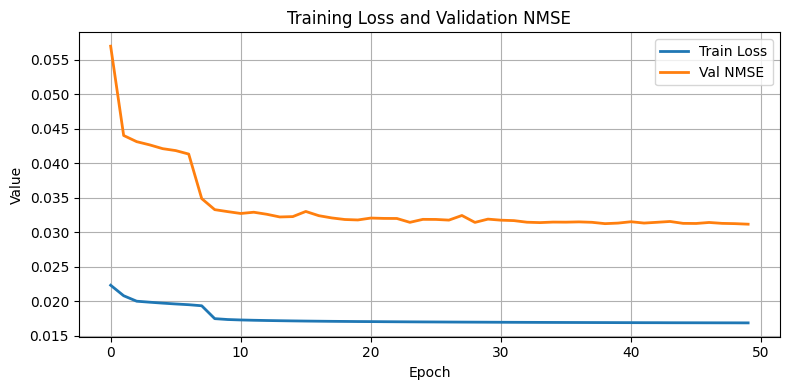

In [7]:
import numpy as np
import matplotlib.pyplot as plt

train_loss = np.load("train_loss_curve.npy")
val_nmse   = np.load("val_nmse_curve.npy")

epochs = range(len(train_loss))

plt.figure(figsize=(8,4))

plt.plot(epochs, train_loss, label="Train Loss", linewidth=2)
plt.plot(epochs, val_nmse, label="Val NMSE", linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Loss and Validation NMSE")
plt.grid(True)
plt.legend()

plt.tight_layout()

# Save the figure
plt.savefig("train_loss_val_nmse2.png", dpi=300, bbox_inches="tight")

plt.show()


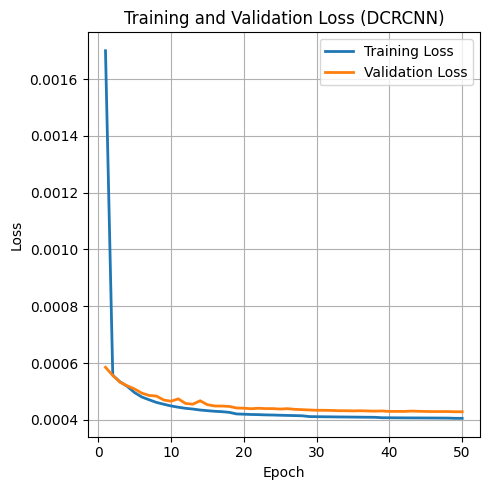

In [4]:
import re
import matplotlib.pyplot as plt

# Paste the FULL console output between triple quotes
log_text = """
============================================================
🔧 TRAINING CONFIGURATION
============================================================
 Save Directory:       ./SavedModels_DCRCNN_full
 Model Dimensions:     320x320
 Epochs:               50
 Learning Rate:        0.0001
 Init Checkpoint:      ./SavedModels_DCRCNN_full\init_ckpt
 Best Checkpoint:      ./SavedModels_DCRCNN_full\best_ckpt
 Final Checkpoint:     ./SavedModels_DCRCNN_full\final_ckpt
============================================================
ℹ️ No checkpoint found. Training from scratch.

🚀 STARTING TRAINING...
============================================================
Epoch 1/50
4338/4338 [==============================] - ETA: 0s - loss: 0.0017      
Epoch 1: val_loss improved from inf to 0.00059, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2717s 624ms/step - loss: 0.0017 - val_loss: 5.8512e-04 - lr: 1.0000e-04
Epoch 2/50
4338/4338 [==============================] - ETA: 0s - loss: 5.5709e-04   
Epoch 2: val_loss improved from 0.00059 to 0.00056, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2710s 625ms/step - loss: 5.5709e-04 - val_loss: 5.5656e-04 - lr: 1.0000e-04
Epoch 3/50
4338/4338 [==============================] - ETA: 0s - loss: 5.3383e-04   
Epoch 3: val_loss improved from 0.00056 to 0.00053, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2711s 625ms/step - loss: 5.3383e-04 - val_loss: 5.3248e-04 - lr: 1.0000e-04
Epoch 4/50
4338/4338 [==============================] - ETA: 0s - loss: 5.1789e-04   
Epoch 4: val_loss improved from 0.00053 to 0.00052, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2710s 625ms/step - loss: 5.1789e-04 - val_loss: 5.1973e-04 - lr: 1.0000e-04
Epoch 5/50
4338/4338 [==============================] - ETA: 0s - loss: 4.9602e-04   
Epoch 5: val_loss improved from 0.00052 to 0.00051, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2715s 626ms/step - loss: 4.9602e-04 - val_loss: 5.0883e-04 - lr: 1.0000e-04
Epoch 6/50
4338/4338 [==============================] - ETA: 0s - loss: 4.8042e-04   
Epoch 6: val_loss improved from 0.00051 to 0.00049, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2708s 624ms/step - loss: 4.8042e-04 - val_loss: 4.9403e-04 - lr: 1.0000e-04
Epoch 7/50
4338/4338 [==============================] - ETA: 0s - loss: 4.7074e-04   
Epoch 7: val_loss improved from 0.00049 to 0.00049, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2709s 625ms/step - loss: 4.7074e-04 - val_loss: 4.8595e-04 - lr: 1.0000e-04
Epoch 8/50
4338/4338 [==============================] - ETA: 0s - loss: 4.6147e-04   
Epoch 8: val_loss improved from 0.00049 to 0.00048, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2714s 626ms/step - loss: 4.6147e-04 - val_loss: 4.8392e-04 - lr: 1.0000e-04
Epoch 9/50
4338/4338 [==============================] - ETA: 0s - loss: 4.5506e-04   
Epoch 9: val_loss improved from 0.00048 to 0.00047, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2709s 625ms/step - loss: 4.5506e-04 - val_loss: 4.7000e-04 - lr: 1.0000e-04
Epoch 10/50
4338/4338 [==============================] - ETA: 0s - loss: 4.4912e-04   
Epoch 10: val_loss improved from 0.00047 to 0.00047, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2710s 625ms/step - loss: 4.4912e-04 - val_loss: 4.6568e-04 - lr: 1.0000e-04
Epoch 11/50
4338/4338 [==============================] - ETA: 0s - loss: 4.4456e-04   
Epoch 11: val_loss did not improve from 0.00047
4338/4338 [==============================] - 2714s 626ms/step - loss: 4.4456e-04 - val_loss: 4.7397e-04 - lr: 1.0000e-04
Epoch 12/50
4338/4338 [==============================] - ETA: 0s - loss: 4.4073e-04   
Epoch 12: val_loss improved from 0.00047 to 0.00046, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2711s 625ms/step - loss: 4.4073e-04 - val_loss: 4.5781e-04 - lr: 1.0000e-04
Epoch 13/50
4338/4338 [==============================] - ETA: 0s - loss: 4.3814e-04   
Epoch 13: val_loss improved from 0.00046 to 0.00046, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2715s 626ms/step - loss: 4.3814e-04 - val_loss: 4.5519e-04 - lr: 1.0000e-04
Epoch 14/50
4338/4338 [==============================] - ETA: 0s - loss: 4.3469e-04   
Epoch 14: val_loss did not improve from 0.00046
4338/4338 [==============================] - 2710s 625ms/step - loss: 4.3469e-04 - val_loss: 4.6735e-04 - lr: 1.0000e-04
Epoch 15/50
4338/4338 [==============================] - ETA: 0s - loss: 4.3240e-04   
Epoch 15: val_loss improved from 0.00046 to 0.00045, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2710s 625ms/step - loss: 4.3240e-04 - val_loss: 4.5344e-04 - lr: 1.0000e-04
Epoch 16/50
4338/4338 [==============================] - ETA: 0s - loss: 4.3024e-04   
Epoch 16: val_loss improved from 0.00045 to 0.00045, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2711s 625ms/step - loss: 4.3024e-04 - val_loss: 4.4892e-04 - lr: 1.0000e-04
Epoch 17/50
4338/4338 [==============================] - ETA: 0s - loss: 4.2886e-04   
Epoch 17: val_loss improved from 0.00045 to 0.00045, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2710s 625ms/step - loss: 4.2886e-04 - val_loss: 4.4868e-04 - lr: 1.0000e-04
Epoch 18/50
4338/4338 [==============================] - ETA: 0s - loss: 4.2652e-04   
Epoch 18: val_loss improved from 0.00045 to 0.00045, saving model to ./SavedModels_DCRCNN_full\best_ckpt

Epoch 18: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
4338/4338 [==============================] - 2709s 624ms/step - loss: 4.2652e-04 - val_loss: 4.4742e-04 - lr: 1.0000e-04
Epoch 19/50
4338/4338 [==============================] - ETA: 0s - loss: 4.2089e-04   
Epoch 19: val_loss improved from 0.00045 to 0.00044, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2712s 625ms/step - loss: 4.2089e-04 - val_loss: 4.4186e-04 - lr: 5.0000e-05
Epoch 20/50
4338/4338 [==============================] - ETA: 0s - loss: 4.1993e-04   
Epoch 20: val_loss improved from 0.00044 to 0.00044, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2714s 626ms/step - loss: 4.1993e-04 - val_loss: 4.4111e-04 - lr: 5.0000e-05
Epoch 21/50
4338/4338 [==============================] - ETA: 0s - loss: 4.1897e-04   
Epoch 21: val_loss improved from 0.00044 to 0.00044, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2713s 625ms/step - loss: 4.1897e-04 - val_loss: 4.3927e-04 - lr: 5.0000e-05
Epoch 22/50
4338/4338 [==============================] - ETA: 0s - loss: 4.1843e-04   
Epoch 22: val_loss did not improve from 0.00044
4338/4338 [==============================] - 2714s 626ms/step - loss: 4.1843e-04 - val_loss: 4.4100e-04 - lr: 5.0000e-05
Epoch 23/50
4338/4338 [==============================] - ETA: 0s - loss: 4.1754e-04   
Epoch 23: val_loss did not improve from 0.00044
4338/4338 [==============================] - 2713s 625ms/step - loss: 4.1754e-04 - val_loss: 4.3961e-04 - lr: 5.0000e-05
Epoch 24/50
4338/4338 [==============================] - ETA: 0s - loss: 4.1707e-04   
Epoch 24: val_loss did not improve from 0.00044
4338/4338 [==============================] - 2713s 625ms/step - loss: 4.1707e-04 - val_loss: 4.3970e-04 - lr: 5.0000e-05
Epoch 25/50
4338/4338 [==============================] - ETA: 0s - loss: 4.1630e-04   
Epoch 25: val_loss improved from 0.00044 to 0.00044, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2713s 625ms/step - loss: 4.1630e-04 - val_loss: 4.3812e-04 - lr: 5.0000e-05
Epoch 26/50
4338/4338 [==============================] - ETA: 0s - loss: 4.1563e-04   
Epoch 26: val_loss did not improve from 0.00044
4338/4338 [==============================] - 2714s 626ms/step - loss: 4.1563e-04 - val_loss: 4.3946e-04 - lr: 5.0000e-05
Epoch 27/50
4338/4338 [==============================] - ETA: 0s - loss: 4.1508e-04   
Epoch 27: val_loss improved from 0.00044 to 0.00044, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2713s 625ms/step - loss: 4.1508e-04 - val_loss: 4.3713e-04 - lr: 5.0000e-05
Epoch 28/50
4338/4338 [==============================] - ETA: 0s - loss: 4.1441e-04   
Epoch 28: val_loss improved from 0.00044 to 0.00044, saving model to ./SavedModels_DCRCNN_full\best_ckpt

Epoch 28: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
4338/4338 [==============================] - 2713s 625ms/step - loss: 4.1441e-04 - val_loss: 4.3602e-04 - lr: 5.0000e-05
Epoch 29/50
4338/4338 [==============================] - ETA: 0s - loss: 4.1163e-04   
Epoch 29: val_loss improved from 0.00044 to 0.00043, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2713s 625ms/step - loss: 4.1163e-04 - val_loss: 4.3485e-04 - lr: 2.5000e-05
Epoch 30/50
4338/4338 [==============================] - ETA: 0s - loss: 4.1122e-04   
Epoch 30: val_loss improved from 0.00043 to 0.00043, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2714s 626ms/step - loss: 4.1122e-04 - val_loss: 4.3380e-04 - lr: 2.5000e-05
Epoch 31/50
4338/4338 [==============================] - ETA: 0s - loss: 4.1093e-04   
Epoch 31: val_loss improved from 0.00043 to 0.00043, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2719s 627ms/step - loss: 4.1093e-04 - val_loss: 4.3372e-04 - lr: 2.5000e-05
Epoch 32/50
4338/4338 [==============================] - ETA: 0s - loss: 4.1064e-04   
Epoch 32: val_loss improved from 0.00043 to 0.00043, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2721s 627ms/step - loss: 4.1064e-04 - val_loss: 4.3324e-04 - lr: 2.5000e-05
Epoch 33/50
4338/4338 [==============================] - ETA: 0s - loss: 4.1031e-04   
Epoch 33: val_loss improved from 0.00043 to 0.00043, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2716s 626ms/step - loss: 4.1031e-04 - val_loss: 4.3232e-04 - lr: 2.5000e-05
Epoch 34/50
4338/4338 [==============================] - ETA: 0s - loss: 4.1011e-04   
Epoch 34: val_loss improved from 0.00043 to 0.00043, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2715s 626ms/step - loss: 4.1011e-04 - val_loss: 4.3215e-04 - lr: 2.5000e-05
Epoch 35/50
4338/4338 [==============================] - ETA: 0s - loss: 4.0980e-04   
Epoch 35: val_loss improved from 0.00043 to 0.00043, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2717s 626ms/step - loss: 4.0980e-04 - val_loss: 4.3164e-04 - lr: 2.5000e-05
Epoch 36/50
4338/4338 [==============================] - ETA: 0s - loss: 4.0952e-04   
Epoch 36: val_loss did not improve from 0.00043
4338/4338 [==============================] - 2717s 626ms/step - loss: 4.0952e-04 - val_loss: 4.3212e-04 - lr: 2.5000e-05
Epoch 37/50
4338/4338 [==============================] - ETA: 0s - loss: 4.0928e-04   
Epoch 37: val_loss improved from 0.00043 to 0.00043, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2740s 632ms/step - loss: 4.0928e-04 - val_loss: 4.3138e-04 - lr: 2.5000e-05
Epoch 38/50
4338/4338 [==============================] - ETA: 0s - loss: 4.0902e-04   
Epoch 38: val_loss improved from 0.00043 to 0.00043, saving model to ./SavedModels_DCRCNN_full\best_ckpt

Epoch 38: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
4338/4338 [==============================] - 2724s 628ms/step - loss: 4.0902e-04 - val_loss: 4.3076e-04 - lr: 2.5000e-05
Epoch 39/50
4338/4338 [==============================] - ETA: 0s - loss: 4.0754e-04   
Epoch 39: val_loss did not improve from 0.00043
4338/4338 [==============================] - 2716s 626ms/step - loss: 4.0754e-04 - val_loss: 4.3135e-04 - lr: 1.2500e-05
Epoch 40/50
4338/4338 [==============================] - ETA: 0s - loss: 4.0739e-04   
Epoch 40: val_loss improved from 0.00043 to 0.00043, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2721s 627ms/step - loss: 4.0739e-04 - val_loss: 4.2972e-04 - lr: 1.2500e-05
Epoch 41/50
4338/4338 [==============================] - ETA: 0s - loss: 4.0723e-04   
Epoch 41: val_loss did not improve from 0.00043
4338/4338 [==============================] - 2716s 626ms/step - loss: 4.0723e-04 - val_loss: 4.2996e-04 - lr: 1.2500e-05
Epoch 42/50
4338/4338 [==============================] - ETA: 0s - loss: 4.0703e-04   
Epoch 42: val_loss improved from 0.00043 to 0.00043, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2717s 626ms/step - loss: 4.0703e-04 - val_loss: 4.2970e-04 - lr: 1.2500e-05
Epoch 43/50
4338/4338 [==============================] - ETA: 0s - loss: 4.0691e-04   
Epoch 43: val_loss did not improve from 0.00043
4338/4338 [==============================] - 2718s 627ms/step - loss: 4.0691e-04 - val_loss: 4.3093e-04 - lr: 1.2500e-05
Epoch 44/50
4338/4338 [==============================] - ETA: 0s - loss: 4.0680e-04   
Epoch 44: val_loss did not improve from 0.00043
4338/4338 [==============================] - 2718s 626ms/step - loss: 4.0680e-04 - val_loss: 4.3025e-04 - lr: 1.2500e-05
Epoch 45/50
4338/4338 [==============================] - ETA: 0s - loss: 4.0666e-04   
Epoch 45: val_loss improved from 0.00043 to 0.00043, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2718s 627ms/step - loss: 4.0666e-04 - val_loss: 4.2965e-04 - lr: 1.2500e-05
Epoch 46/50
4338/4338 [==============================] - ETA: 0s - loss: 4.0654e-04   
Epoch 46: val_loss improved from 0.00043 to 0.00043, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2718s 626ms/step - loss: 4.0654e-04 - val_loss: 4.2922e-04 - lr: 1.2500e-05
Epoch 47/50
4338/4338 [==============================] - ETA: 0s - loss: 4.0640e-04   
Epoch 47: val_loss did not improve from 0.00043
4338/4338 [==============================] - 2717s 626ms/step - loss: 4.0640e-04 - val_loss: 4.2926e-04 - lr: 1.2500e-05
Epoch 48/50
4338/4338 [==============================] - ETA: 0s - loss: 4.0627e-04   
Epoch 48: val_loss did not improve from 0.00043

Epoch 48: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
4338/4338 [==============================] - 2716s 626ms/step - loss: 4.0627e-04 - val_loss: 4.2938e-04 - lr: 1.2500e-05
Epoch 49/50
4338/4338 [==============================] - ETA: 0s - loss: 4.0549e-04   
Epoch 49: val_loss improved from 0.00043 to 0.00043, saving model to ./SavedModels_DCRCNN_full\best_ckpt
4338/4338 [==============================] - 2717s 626ms/step - loss: 4.0549e-04 - val_loss: 4.2857e-04 - lr: 6.2500e-06
Epoch 50/50
4338/4338 [==============================] - ETA: 0s - loss: 4.0539e-04   
Epoch 50: val_loss did not improve from 0.00043
4338/4338 [==============================] - 2716s 626ms/step - loss: 4.0539e-04 - val_loss: 4.2863e-04 - lr: 6.2500e-06

✅ TRAINING COMPLETED
✅ Final weights saved to ./SavedModels_DCRCNN_full\final_ckpt

📊 TRAINING ANALYSIS
============================================================
 Best Epoch: 49
 Best Val Loss: 0.000429
"""

# -----------------------------
# Extract losses using regex
# -----------------------------
train_loss = []
val_loss = []

for line in log_text.splitlines():
    m = re.search(r"loss:\s*([0-9.eE+-]+)\s+-\s+val_loss:\s*([0-9.eE+-]+)", line)
    if m:
        train_loss.append(float(m.group(1)))
        val_loss.append(float(m.group(2)))

epochs = range(1, len(train_loss) + 1)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(5,5))
plt.plot(epochs, train_loss, label="Training Loss", linewidth=2)
plt.plot(epochs, val_loss, label="Validation Loss", linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (DCRCNN)")
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.savefig("train_val_loss_from_log.png", dpi=300, bbox_inches="tight")
plt.show()
